In [1]:
import numpy as np

# 车辆数量
m = 51
# 路线数量
n = 9
# 车辆行驶时间矩阵
t = np.random.rand(m, n)
# 车辆容量
c = np.random.randint(13, 27, m)
# 路线需求
d = np.random.randint(10, 30, n)

# 遗传算法参数
pop_size = 100  # 种群大小
max_generations = 200  # 最大迭代次数
mutation_rate = 0.01  # 变异率

# 初始化种群
pop = np.random.randint(0, 2, (pop_size, m * n))

for generation in range(max_generations):
    # 计算适应度值
    fitness = []
    for individual in pop:
        x = individual.reshape(m, n)
        T = np.sum(t * x)
        fitness.append(1 / T)
    fitness = np.array(fitness)

    # 选择操作
    selection_probs = fitness / np.sum(fitness)
    selected_indices = np.random.choice(pop_size, pop_size, p=selection_probs)
    new_pop = pop[selected_indices]

    # 交叉操作
    for i in range(0, pop_size, 2):
        parent1 = new_pop[i]
        parent2 = new_pop[i + 1]
        crossover_point = np.random.randint(1, m * n)
        child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
        new_pop[i] = child1
        new_pop[i + 1] = child2

    # 变异操作
    for individual in new_pop:
        for i in range(m * n):
            if np.random.rand() < mutation_rate:
                individual[i] = 1 - individual[i]

    pop = new_pop

# 找到最优方案
best_index = np.argmax(fitness)
best_solution = pop[best_index].reshape(m, n)
best_time = np.sum(t * best_solution)
print("最优运输时间:", best_time)


最优运输时间: 94.6572164215547


请输入地铁线路（格式示例：1号线：A站，B站，C站），输入空行结束：


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



线路信息表：
Empty DataFrame
Columns: [线路名称, 站点列表]
Index: []


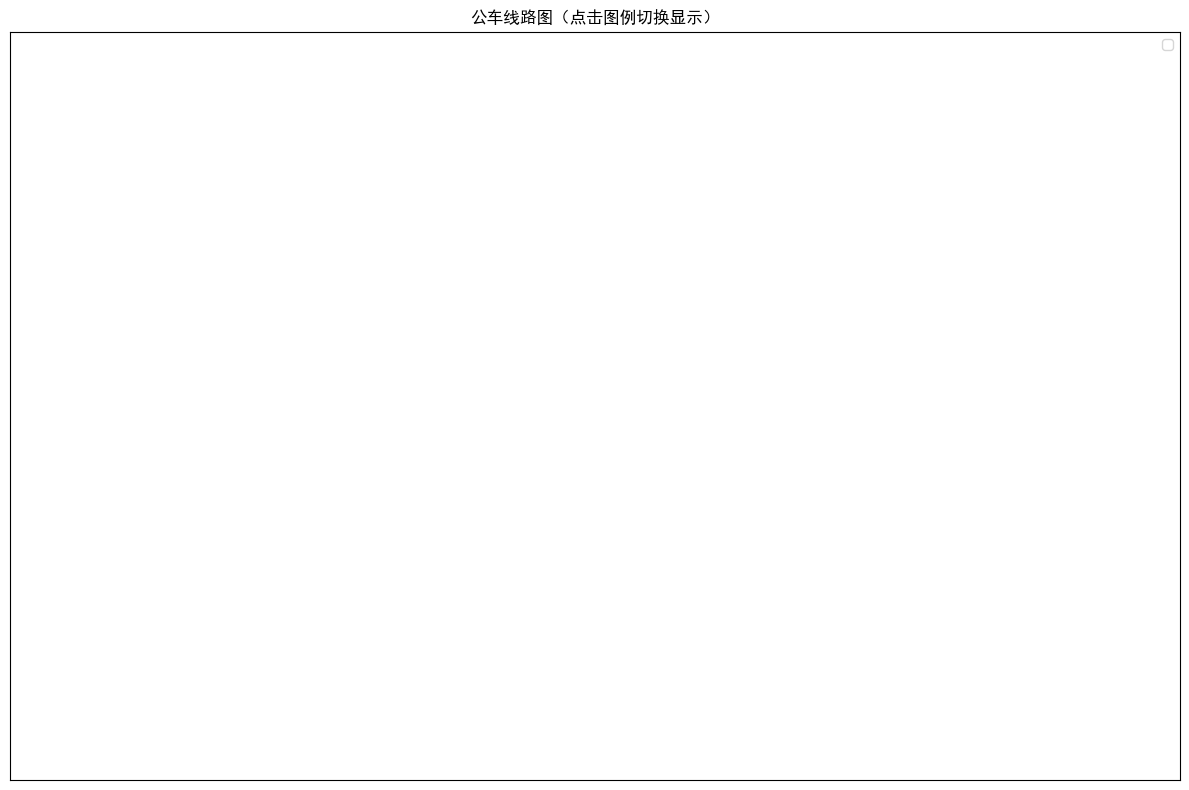

In [3]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib import rcParams
from collections import defaultdict

# 设置中文字体
rcParams['font.sans-serif'] = ['SimHei']
rcParams['axes.unicode_minus'] = False

def on_legend_click(event):
    """图例点击事件处理"""
    legend_line = event.artist
    line_name = legend_line.get_label()
    if line_name in lined:
        visibility = not lined[line_name][0].get_visible()
        for line in lined[line_name]:
            line.set_visible(visibility)
        plt.draw()

# 用户输入处理
def get_user_input():
    print("请输入地铁线路（格式示例：1号线：A站，B站，C站），输入空行结束：")
    lines = []
    while True:
        s = input().strip()
        if not s:
            break
        if ':' not in s:
            print(f"格式错误：'{s}' 请使用中文冒号！")
            continue
        name, stations = s.split(':', 1)
        stations = [s.strip() for s in stations.split(',')]
        lines.append((name.strip(), stations))
    return lines

# 主逻辑
if __name__ == "__main__":
    # 获取输入
    lines = get_user_input()
    
    # 构建网络图
    G = nx.Graph()
    edge_to_lines = defaultdict(list)
    for idx, (name, stations) in enumerate(lines):
        for i in range(len(stations)-1):
            u, v = stations[i], stations[i+1]
            edge = tuple(sorted([u, v]))
            edge_to_lines[edge].append(name)
            G.add_edge(u, v)
    
    # 自动布局
    pos = nx.kamada_kawai_layout(G, dim=2)
    
    # 创建图表
    plt.figure(figsize=(12, 8))
    ax = plt.gca()
    
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightgray', ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=10, ax=ax)
    
    # 颜色分配
    color_map = plt.cm.tab10.colors[:len(lines)]
    
    # 曲线绘制核心代码
    lined = {}
    for idx, (name, stations) in enumerate(lines):
        color = color_map[idx]
        line_segments = []
        
        for i in range(len(stations)-1):
            u, v = stations[i], stations[i+1]
            edge = tuple(sorted([u, v]))
            
            # 获取线路信息
            total = len(edge_to_lines[edge])
            position = edge_to_lines[edge].index(name)
            
            # 动态曲率控制
            start = pos[u]
            end = pos[v]
            dx = end[0] - start[0]
            dy = end[1] - start[1]
            edge_length = np.hypot(dx, dy)
            curvature = 0.15 * edge_length  # 优化后的曲率系数
            
            # 生成贝塞尔曲线
            if position == 0:
                # 主线路保持直线
                vertices = [start, end]
                codes = [Path.MOVETO, Path.LINETO]
            else:
                # 智能弯曲方向
                direction = -1 if position % 2 else 1
                angle = np.arctan2(dy, dx)
                
                # 控制点计算
                ctrl1 = [
                    start[0] + curvature * np.cos(angle - np.pi/2 * direction),
                    start[1] + curvature * np.sin(angle - np.pi/2 * direction)
                ]
                ctrl2 = [
                    end[0] - curvature * np.cos(angle + np.pi/2 * direction),
                    end[1] - curvature * np.sin(angle + np.pi/2 * direction)
                ]
                
                vertices = [start, ctrl1, ctrl2, end]
                codes = [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4]
            
            # 创建路径
            path = Path(vertices, codes)
            patch = patches.PathPatch(
                path,
                lw=2,
                edgecolor=color,
                facecolor='none',
                alpha=0.8
            )
            line = ax.add_patch(patch)
            line_segments.append(line)
        
        lined[name] = line_segments
        # 添加图例代理
        ax.plot([], [], color=color, label=name, lw=2)
    
    # 交互图例
    legend = ax.legend(loc='upper right')
    for legend_line in legend.get_lines():
        legend_line.set_picker(5)
    plt.connect('pick_event', on_legend_click)
    
    # 显示表格
    df = pd.DataFrame([(name, '→'.join(stations)) for name, stations in lines],
                     columns=['线路名称', '站点列表'])
    print("\n线路信息表：")
    print(df.to_string(index=False))
    
    plt.title("公车线路图（点击图例切换显示）")
    plt.tight_layout()
    plt.show()
    